# Szyfrowanie w pełni holomorficzne - Laboratorium 02

## Zadanie 1.

Skopiuj kod pierścienia $\mathbb{Z}_{17}[X]/(X^4+1)$ wraz z arytmetyką oraz kod uproszczonej wersji algorytmu BGV z poprzednich zajęć - przydadzą się.

In [1]:
# pierścień Rq

import numpy as np

x4p1 = np.array([1, 0, 0, 0, 1])

class Z17:
    def __init__(self, poly: np.array):
        _, p = np.polydiv(poly, x4p1)
        self.poly = np.array([0,0,0,0])
        self.poly[-(p.shape[0]):] = p
        self.poly %= 17

    def __mul__(self, other):
        if isinstance(other, Z17):
            return Z17(np.polymul(self.poly, other.poly))
        return Z17(self.poly * other)

    __rmul__ = __mul__

    def __add__(self, other):
        return Z17(np.polyadd(self.poly, other.poly))

    __radd__ = __add__

    def __neg__(self):
        return -1 * self
    
    def __mod__(self, other):
        return Z17(self.poly % other)
    
    def __eq__(self,other):
        return self.poly == other.poly

    def __repr__(self):
        p =  [(f"{a}" if a != 1 else "") + f"x^{3 - i}" for i, a in enumerate(self.poly[:-1].astype(int)) if a != 0] 
        if self.poly[-1] != 0:
            p += [f"{int(self.poly[-1])}"]
        return " +".join(p)

In [2]:
# algorytm BGV

n = 4 
q = 17
t = 2

prob = 0.975

def SecretKeyGen(n):
    # sk =  np.random.binomial(2,0.5,size=n)-1
    sk = np.random.choice([-1,0,1],n,p=[0.,prob,1-prob])
    return Z17(sk)

def PubKeyGen(sk):
    a = Z17(np.random.randint(q,size=n))
    e = Z17(np.random.choice([-1,0,1],n,p=[(1-prob)/2,prob,(1-prob)/2]))
    
    pk0 = a*sk + t*e
    pk1 = -a
    return (pk0,pk1)

def Encrypt(m,pk):
    e0 = Z17(np.random.choice([-1,0,1],n,p=[(1-prob)/2,prob,(1-prob)/2]))
    e1 = Z17(np.random.choice([-1,0,1],n,p=[(1-prob)/2,prob,(1-prob)/2]))
    u = Z17(np.random.choice([-1,0,1],n,p=[0.,prob,1-prob]))
    c0 = pk[0]*u + t*e0 + m
    c1 = pk[1]*u + t*e1
    return (c0,c1)

def Decrypt(c, sk):
    m = c[0] + c[1]*sk
    # m %= q # implicitly handled above
    # m %= t # this step ruins the encryption for larger polynomials
    return m

In [3]:
sk = SecretKeyGen(n)
pk = PubKeyGen(sk)

## Dodawanie `Add`

Załóżmy, że mamy dwie wiadomości zaszyfrowane tym samym kluczem prywatnym, tzn. dwie pary $(c_0,c_1)$ oraz $(c'_0,c'_1)$. Naturalnym sposobem zdefiniowania sumy jest $$c_0^{\ast}=c_0+c'_0$$ $$c_1^{\ast}=c_1+c'_1$$czyli szyfrogram sumy to $$c^{\ast}=(c_0^{\ast},c_1^{\ast}).$$

To podejście me jeden problem: z każdą operacją sumowania wzrasta zaszumienie końcowego szyfrogramu, co może skutkować błędnym deszyfrowaniem, jednak nie aż tak bardzo jak to się dzieje w przypadku mnożenia.

## Mnożenie `Mul`

Jak przy dodawaniu mamy dwie wiadomości zaszyfrowane tym samym kluczem prywatnym, tzn. dwie pary $(c_0,c_1)$ oraz $(c'_0,c'_1)$. W przypadku naturalnej definicji mnożenia sprawy się komplikują: jeżeli popatrzymy na funkcję `Decrypt`, to wiadomości $m$ i $m'$ kryjące się za naszymi szyfrogramami są postaci $$m=c_0+c_1s$$ $$m'=c'_0+c'_1s.$$Jeżeli teraz pomnożymy te dwie wiadomości, to otrzymamy $$mm'=(c_0+c_1s)(c'_0+c'_1s)=c_0c'_0+(c_0c'_1+c'_0c_1)s+c_1c'_1s^2$$
Otrzymujemy zatem **trzy** współrzędne końcowego szyfrogramu:
\begin{eqnarray*}
c^{\ast}_0=c_0c'_0\\
c^{\ast}_1=c_0c'_1+c'_0c_1\\
c^{\ast}_2=c_1c'_1
\end{eqnarray*}
Jako wynik mnożenia zwracamy szyfrogram $$c^{\ast}=(c_0^{\ast},c_1^{\ast},c_2^{\ast}).$$
W tym przypadku oprócz problemu z narastającym zaszumieniem mamy jeszcze problem z dodatkową współrzędną, której nie bierze pod uwagę nasza implementacja funkcji deszyfrującej.

## Prosta relinearyzacja `KeySwitch`

Niech $c^{\ast}=(c_0^{\ast},c_1^{\ast},c_2^{\ast})$ będzie wynikiem mnożenia dwóch wiadomości $m_1$ i $m_2$ zaszyfrowanych przy pomocy klucza publicznego $(pk_0, pk_1)$ i klucza prywatnego $s$. Żeby pozbyć się współrzędnej $c_2^{\ast}$ (i przekształcić postać iloczynu $mm'$ z kwadratowej na liniową) stosujemy *zmianę klucza*.

**Krok 1 - rozkład wielomianu.** Najpierw zapisujemy wszystkie współczynniki wielomianu $c_2^{\ast}=w_0+w_1x+w_2x^2+w_3x^3$ w reprezentacji w systemie dwójkowym, tzn. $$w_i=\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}2^jw^{(j)}_i,\ \ i=0,1,2,3$$

Konstruujemy nowe wielomiany dla $j=0,...,\lfloor \log_2 q\rfloor+1$ $$c_2^{\ast (j)}=w^{(j)}_0+w^{(j)}_1x+w^{(j)}_2x^2+w^{(j)}_3x^3$$i za ich pomocą rozkładamy wielomian $c_2^{\ast}$ $$c_2^{\ast}=\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}2^j c_2^{\ast (j)}\mod q$$

**Krok 2 - generowanie wskazówek.** Dla $j=0,...,\lfloor \log_2 q\rfloor+1$ z klucza prywatengo $s$ generujemy tzw. *wskazówki*: $$(ek_0^{(j)},ek_1^{(j)})=(a_js+te_j+2^js^2,-a_j),$$gdzie $a_j\in R_q$ są generowane losowo z rozkładu jednostajnego a błedy $e_i\in R_q$ - losowo z rozkładu typu Gaussowskiego (jak przy generowaniu kluczy).

**Krok 3 - nowy szyfrogram.** Generujemy nowy szyfrogram $(\widehat{c}_0,\widehat{c}_1)$: $$\widehat{c}_0=c_0^{\ast}+\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}ek_0^{(j)}c_2^{\ast (j)}$$
$$\widehat{c}_1=c_1^{\ast}+\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}ek_1^{(j)}c_2^{\ast (j)}$$

Po zdeszyfrowaniu $(\widehat{c}_0,\widehat{c}_1)$ z kluczem $s$ powinniśmy otrzymać wiadomość będącą wynikiem mnożenia dwóch wiadomości $m_1$ i $m_2$.

## Zadanie 2.

Zaimplementuj funkcje `Add`, `KeySwitch` oraz `Mul` realizujące powyższe algorytmy.
- sprawdź działanie dodawania i mnożenia dla jednej operacji ($m_1+m_2, m_1*m_2$). Pamiętaj o wykorzystaniu funkcji `KeySwitch` przy mnożeniu. Dobierz parametry kryptosystemu tak, żeby po deszyfrowaniu otrzymać poprawne wyniki.
- ile operacji dodawania możemy wykonać zanim narastające błędy spowodują błędne deszyfrowanie ($m_1+m_2+m_3+...$)?
- a ile operacji mnożenia ($m_1*m_2*m_3*...$)?
- sprawdź jak wygląda skuteczność deszyfrowania w przypadku mieszania operacji, np. $m_1*m_2+m_3$. Dla jakiej głębokości $N$ operacji mieszanych na wiadomościach deszyfrowanie jest poprawne?

Przez głębokość $N$ operacji mieszanych rozumiemy kombinację postaci: iloczyn $N$ wiadomości plus iloczyn $N-1$ wiadomości plus iloczyn $N-2$ wiadomości plus ... plus iloczyn dwóch wiadomości plus jedna wiadomość.

Otrzymane rezultaty (maksymalna głębokość operacji dodawania, operacji mnożenia i operacji mieszanych) opisz pełnym zdaniem w osobnej komórce pod testami.

In [4]:
# Add
def add_z17(c_x,c_y):
    return (c_x[0]+c_y[0],c_x[1]+c_y[1])

# KeySwitch
pow_max = np.floor(np.log2(q)).astype(int)+1

def key_switch(c_x,c_y,c_z):
    W = np.zeros(shape = (c_z.poly.shape[0],pow_max))
    
    for i, w in enumerate(c_z.poly):
        for j, wj in enumerate(bin(w)[-1:1:-1]):
            W[i][j] = int(wj)
    
    c2 = [Z17(p[::-1]) for p in W.T]
    
    A = [Z17(np.random.randint(q,size=n)) for j in range(W.shape[1])]
    E = [Z17(np.random.choice([-1,0,1],n,p=[(1-prob)/2,prob,(1-prob)/2])) for j in range(W.shape[1])]
    
    ek0 = [A[j]*sk + E[j]*t + 2**j * sk*sk for j in range(W.shape[1])]
    ek1 = [-1*a for a in A]
   
    c0 = c_x
    for c,ek in zip(c2,ek0):
        c0 += c*ek
    
    c1 = c_y
    for c,ek in zip(c2,ek1):
        c1 += c*ek
    
    return (c0,c1)

# Mul

def mul_z17(c_x,c_y):
    c0 = c_x[0]*c_y[0]
    c1 = (c_x[0]*c_y[1] + c_x[1]*c_y[0])*sk
    c2 = c_x[1]*c_y[1]*sk*sk
    return key_switch(c0,c1,c2)


### Opis rezultatów - TODO



# Analiza resultatów dla pojedynczego przykładu

In [5]:
a, b = Z17(np.random.randint(q,size=n)),Z17(np.random.randint(q,size=n))

# suma i iloczyn oryginalnych wielomianów
ab_mul = a*b
ab_sum = a+b

# zaszyfrowanie oryginałów
a_encrypted, b_encrypted = Encrypt(a,pk),Encrypt(b,pk)

# mnożenie zaszyfrowanych wielomianów
ab_mul_encrypted = mul_z17(a_encrypted,b_encrypted)
ab_sum_encrypted = add_z17(a_encrypted,b_encrypted)

# odszyfrowanie wymnożonych wielomianó
ab_mul_decrypted = Decrypt(ab_mul_encrypted,sk)
ab_sum_decrypted = Decrypt(ab_sum_encrypted,sk)

print("suma")
print(ab_sum)
print(ab_sum_decrypted,end="\n\n")

print("iloczyn")
print(ab_mul)
print(ab_mul_decrypted)


suma
13x^3 +13x^2 +15x^1 +4
13x^3 +13x^2 +15x^1 +4

iloczyn
7x^3 +5x^2 +16x^1
7x^3 +5x^2 +16x^1


# Badanie sumy

Wykonujemy 30 powtórzeń i uśredniamy wynik. Sprawdzamy ile współczynników wielomianu odszyfrowanego zgadza się ze współczynnikami oryginału dla różnej liczby dodawań

In [6]:
N = 30
n_repeats = 20

print()
scores = []
for repeat in range(n_repeats):
    original_sum = Z17([0,0,0,0])
    encrypted_sum = Encrypt(original_sum,pk)
    scores.append([])
    for depth in range(1,N+1):
        original_poly = Z17(np.random.randint(q,size=n))
        encrypted_poly = Encrypt(original_poly,pk)
        
        original_sum += original_poly
        encrypted_sum = add_z17(encrypted_sum,encrypted_poly)
        decrypted_sum = Decrypt(encrypted_sum, sk)
    
        score = (original_sum.poly == decrypted_sum.poly).sum()/4
        scores[-1].append(score)    

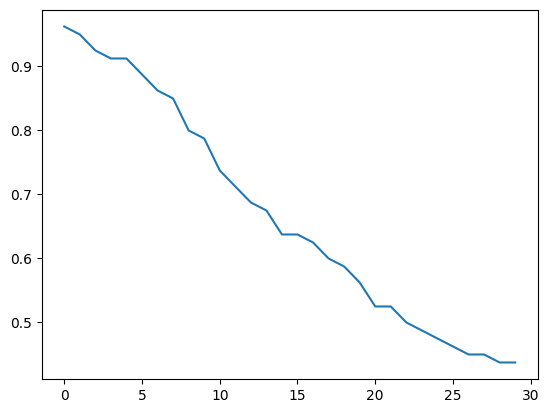

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.mean(scores,0))
plt.show()

Widzimy, że dla dobranych parametrów w miare zwiększania liczby dodawań zwiększa się błąd systemu

# Badanie mnożenia

Mnożenie badamy analogicznie jak dodawanie

In [8]:
N = 30
n_repeats = 20

scores = []
for repeat in range(n_repeats):
    original_mul = Z17(np.random.randint(q,size=n))
    encrypted_mul = Encrypt(original_mul,pk)
    scores.append([])
    for depth in range(1,N+1):
        original_poly = Z17(np.random.randint(q,size=n))
        encrypted_poly = Encrypt(original_poly,pk)
        
        original_mul *= original_poly
        encrypted_mul = mul_z17(encrypted_mul,encrypted_poly)
        decrypted_mul = Decrypt(encrypted_mul, sk)
    
        score = (original_mul.poly == decrypted_mul.poly).sum()/4
        scores[-1].append(score)

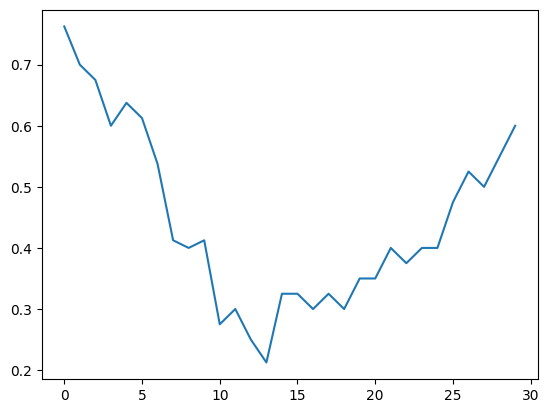

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.mean(scores,0))
plt.show()

Otrzymujemy bardzo dziwne zjawisko. wynik gwałtownie spada jednak dla większej liczby powtórzeń dokładność spowrotem wzrasta.

# Operacje mieszane

Badamy je analogicznie jak dodawanie i mnożenie ale tym razem postępujemy zgodnie z treścią zadania. Badamy sumy iloczynów.

n-tym kroku naszego powtórzenia eksperymentu dodajemy n wymnożonych wartości do wyniku n poprzednich dodawań

In [10]:
N = 30
n_repeats = 20

scores = []
for repeat in range(n_repeats):
    original_sum = Z17([0,0,0,0])
    encrypted_sum = Encrypt(original_sum,pk)
    scores.append([])
    for depth in range(1,N+1):
        original_polys = [Z17(np.random.randint(q,size=n)) for _ in range(depth)]
        encrypted_polys = [Encrypt(p,pk) for p in original_polys]
        
        multiplied_original = original_polys[0]
        for i in range(1,depth):
            multiplied_original = multiplied_original*original_polys[i]
        
        multiplied_encrypted = encrypted_polys[0]
        for i in range(1,depth):
            multiplied_encrypted = mul_z17(multiplied_encrypted,encrypted_polys[i]) 
        
        original_sum += multiplied_original
        encrypted_sum = add_z17(encrypted_sum,multiplied_encrypted)
        decrypted_sum = Decrypt(encrypted_sum, sk)
    
        score = (original_sum.poly == decrypted_sum.poly).sum()/4
        scores[-1].append(score)        

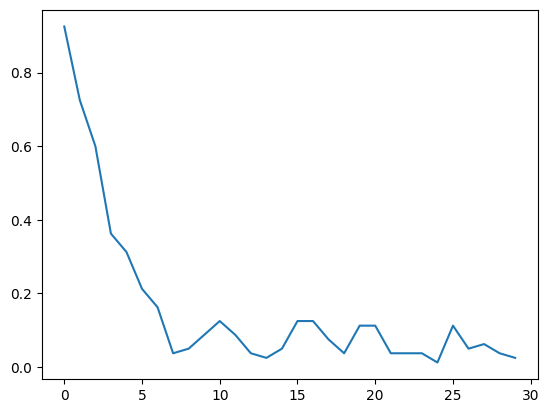

In [11]:
import matplotlib.pyplot as plt

plt.plot(np.mean(scores,0))
plt.show()

Takie wyniki szybko tracą dokładność. Prawdopodobnie użycie bardziej złożonego systemu pozwoliłoby na większą dokładność